In [ ]:
pip install xgb

In [21]:
pip install nixtla

Note: you may need to restart the kernel to use updated packages.


Using transfer methods other methods especially for time series predictions proved to have some bias and were not accurate. So for accuracy we leveraged on NIXTLA TimeGPT model to predict the prices of Rice in Ghana using economic extrogenous features 

# Imports

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from nixtla import NixtlaClient
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
from utilsforecast.losses import mae



In [68]:
file_path = '/Users/senamdzomeku/Downloads/research/rice prices with exogenous.csv'
df = pd.read_csv(file_path)

# Data Preprocessing / Exploratory Data Analysis

In [69]:
# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)

df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# Convert to 'YYYY-MM-DD' format, start of the month
df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp()

In [70]:
eda = df.copy()

In [71]:
eda.set_index('ds', inplace=True)

In [72]:
eda.head()

,riceusdprice,maizeusdprice,exchangerate,Inflation
ds,,,,
2007-01-01,37.844100,20.495183,0.9210,18.541578
2007-02-01,36.425600,22.002383,0.9295,14.262831
2007-03-01,36.701883,23.088567,0.9263,13.017348
2007-04-01,37.661983,24.117650,0.9270,12.367792
2007-05-01,38.772450,24.460667,0.9276,12.314164


# Visualisation/EDA

In [73]:
eda.describe()

,riceusdprice,maizeusdprice,exchangerate,Inflation
count,199.000000,199.000000,199.000000,199.000000
mean,55.245394,37.533759,3.831651,19.504045
std,14.004332,9.662863,2.754113,12.281528
min,33.153808,20.495183,0.921000,8.405687
25%,45.190233,30.470422,1.505250,10.798171
50%,49.494950,35.937100,3.773800,15.441009
75%,66.878801,42.164807,5.425000,20.946911
max,84.441483,67.216371,14.400000,55.755276


## Plotting features

### Target Variable (Rice Prices)

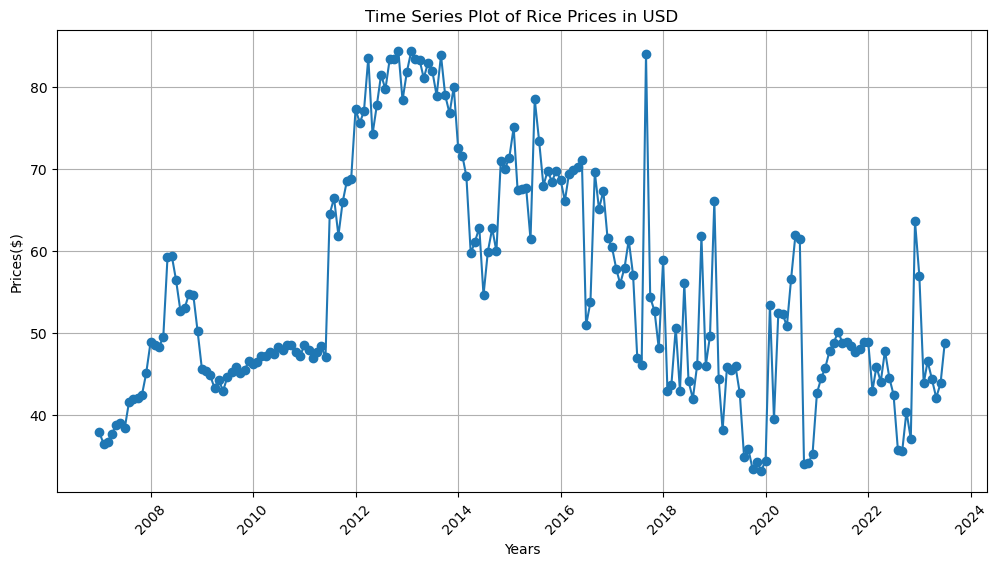

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['riceusdprice'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Prices($)')
plt.title('Time Series Plot of Rice Prices in USD')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


### Maize Prices

Included in analysis because maize is considered a substitute to rice, (demand side factors)

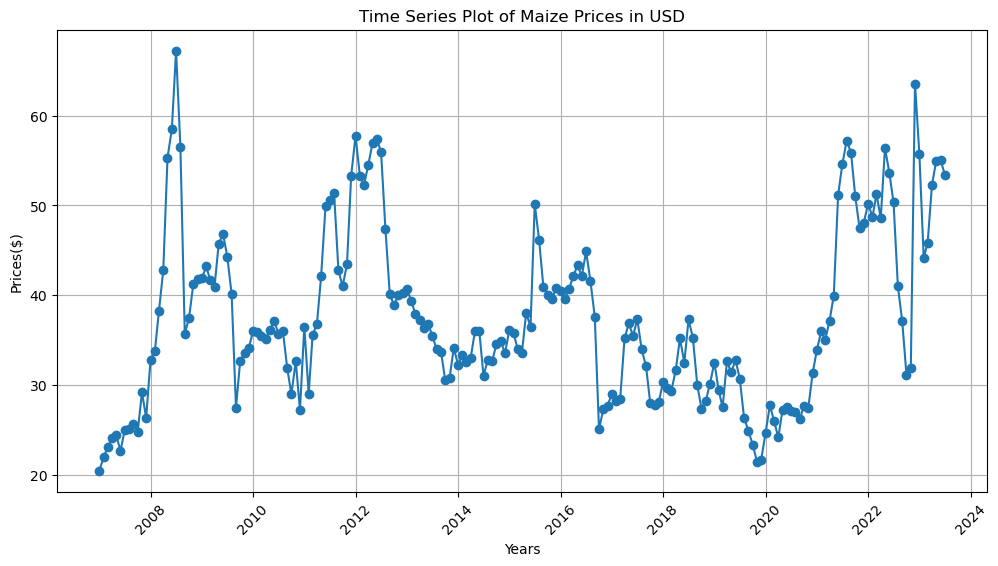

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['maizeusdprice'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Prices($)')
plt.title('Time Series Plot of Maize Prices in USD')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

### Exchange Rate

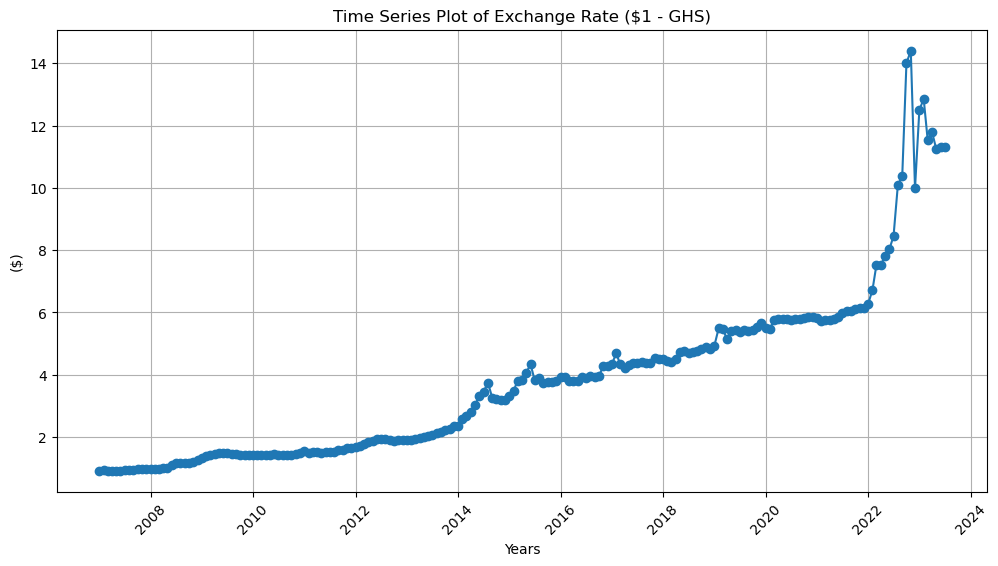

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['exchangerate'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('($)')
plt.title('Time Series Plot of Exchange Rate ($1 - GHS)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## Inflation Rate

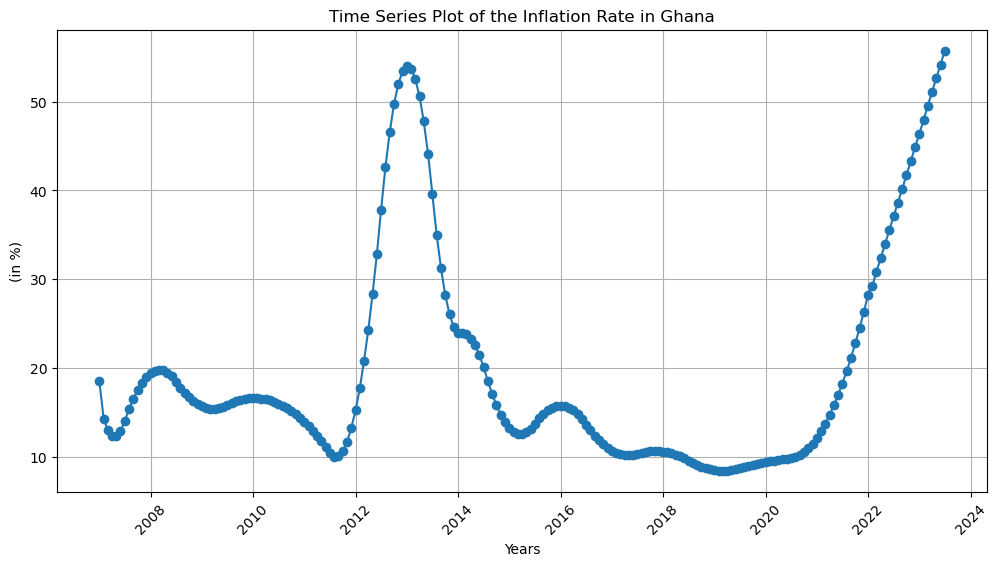

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['Inflation'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('(in %)')
plt.title('Time Series Plot of the Inflation Rate in Ghana')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## Correlation Analysis

In [78]:
# Calculate the correlation matrix
correlation_matrix = df[['riceusdprice', 'maizeusdprice','exchangerate','Inflation']].corr()

print(correlation_matrix)


               riceusdprice  maizeusdprice  exchangerate  Inflation
riceusdprice       1.000000       0.269918     -0.278425   0.316512
maizeusdprice      0.269918       1.000000      0.145797   0.427938
exchangerate      -0.278425       0.145797      1.000000   0.318873
Inflation          0.316512       0.427938      0.318873   1.000000


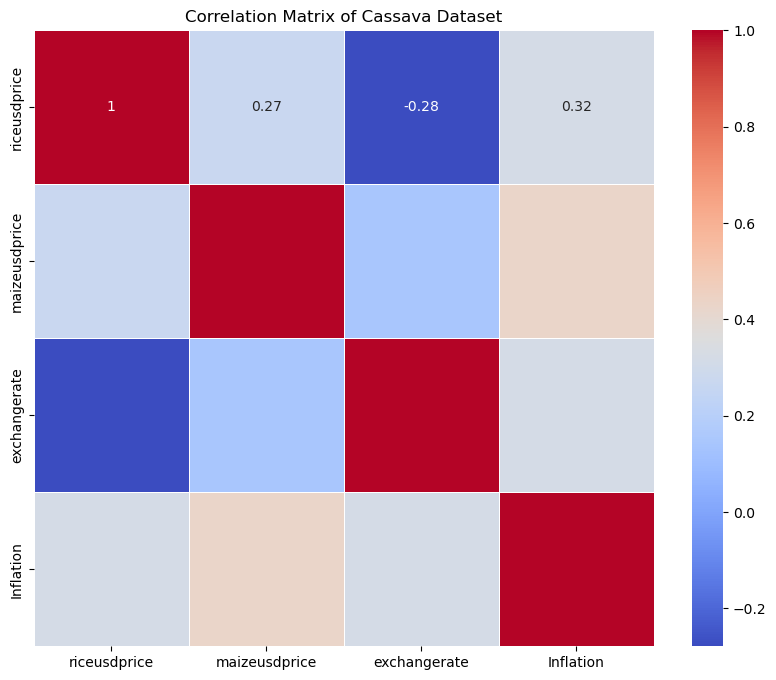

In [79]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Cassava Dataset')
plt.show()

From the correlation matrix we see that there is no multicolinearity in the model and all extrogenous features have some correlation to the target variable (riceusdprice)

In [80]:
#function for scaling
def standard_scale_features(df, feature_columns):
    """
    Parameters:
    df (pd.DataFrame):
    feature_columns (list)
    """
    scaler = StandardScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df

## Using tree models to confirm feature importance

In [82]:
col_scale = ['riceusdprice', 'maizeusdprice', 'exchangerate', 'Inflation']
standard_scale_features (eda,col_scale)

,riceusdprice,maizeusdprice,exchangerate,Inflation
ds,,,,
2007-01-01,-1.245699,-1.767752,-1.059503,-0.078565
2007-02-01,-1.347244,-1.611380,-1.056409,-0.427832
2007-03-01,-1.327466,-1.498689,-1.057574,-0.529499
2007-04-01,-1.258736,-1.391921,-1.057319,-0.582521
2007-05-01,-1.179242,-1.356333,-1.057101,-0.586899
...,...,...,...,...
2023-03-01,-0.624812,0.860623,2.809549,2.450652
2023-04-01,-0.782726,1.532878,2.900551,2.577772
2023-05-01,-0.943091,1.807497,2.700346,2.704892


In [83]:
#Splitting features and target
X = eda.drop(columns=['riceusdprice'])
y = eda['riceusdprice']

# Convert feature names to strings
feature_names = [str(name) for name in X.columns]

Using XGboost and Random Tree to assess feature importance

In [84]:
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, shuffle = False)
xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "shuffle" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_

# Create DataFrames for easier comparison
import pandas as pd

# Assuming X_train.columns contains feature names
feature_names = X_train.columns

importances_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': importances_rf
}).sort_values(by='Random Forest Importance', ascending=False)

importances_xgb_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost Importance': importances_xgb
}).sort_values(by='XGBoost Importance', ascending=False)


In [86]:
importances_xgb_df

,Feature,XGBoost Importance
1,exchangerate,0.812465
2,Inflation,0.098489
0,maizeusdprice,0.089046


In [87]:
importances_rf_df

,Feature,Random Forest Importance
1,exchangerate,0.725861
2,Inflation,0.139825
0,maizeusdprice,0.134313


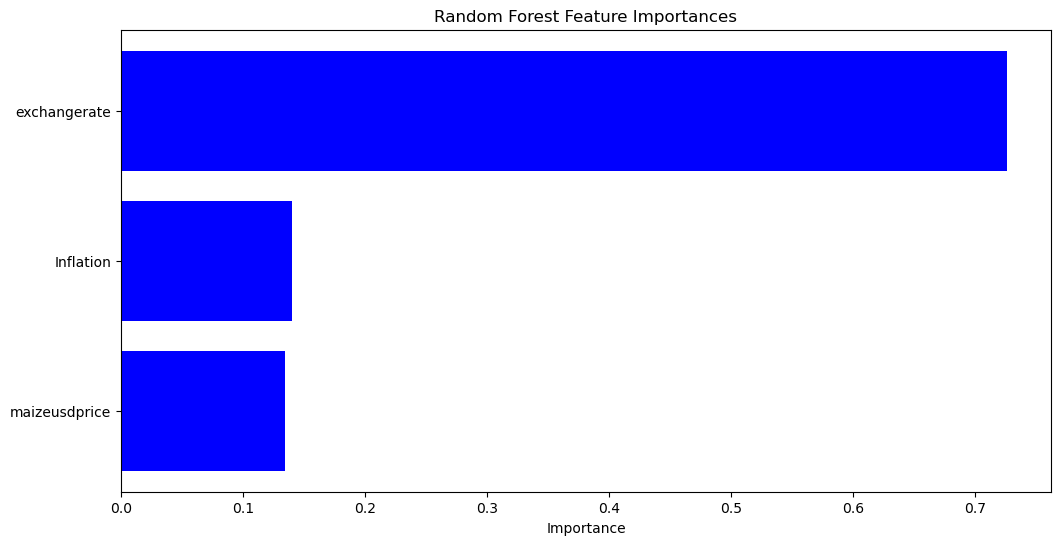

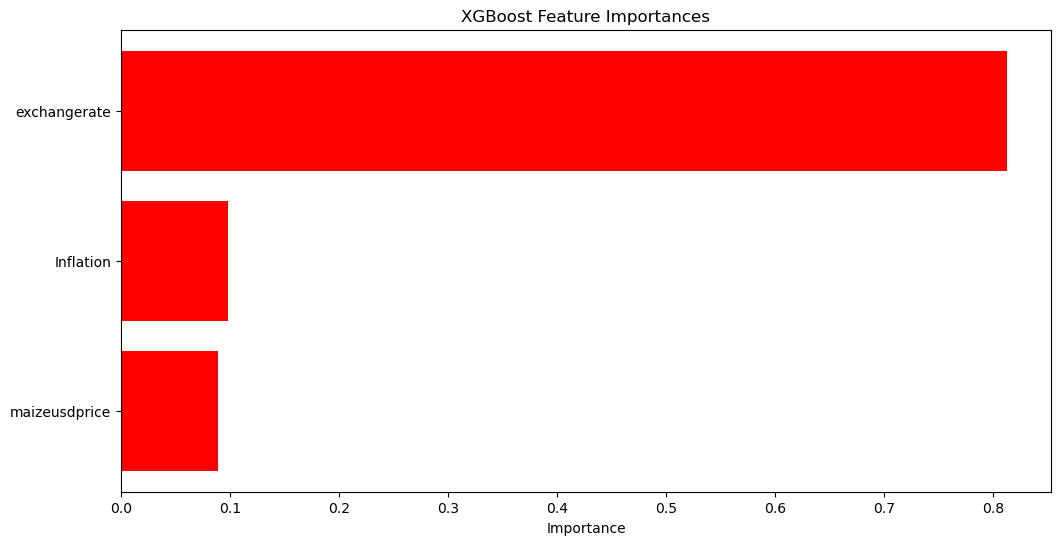

In [88]:
# Plot Random Forest feature importances
plt.figure(figsize=(12, 6))
plt.barh(importances_rf_df['Feature'], importances_rf_df['Random Forest Importance'], color='b')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Plot XGBoost feature importances
plt.figure(figsize=(12, 6))
plt.barh(importances_xgb_df['Feature'], importances_xgb_df['XGBoost Importance'], color='r')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()


The results show that Exchange rate is the most important feature, but to confirm we will use the TimeGPT model to confirm

# Functions

In [89]:
def forecast_with_nixtla(client, df, h, exogenous_df):
    forecast = client.forecast(
        df=df,
        h=h,
        target_col='riceusdprice',
        X_df=exogenous_df
    )
    return forecast


In [90]:
def convert_to_start_of_month(df, date_column):
   
    # Convert the column to datetime format
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m-%d')
    
    # Convert to 'YYYY-MM-DD' format, set to the start of the month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp()
    
    return df

# Training TimeGPT model

Aim is to predict the Rice price from 2023-07 to 2024-07

In [22]:
nix_df = df.copy()

In [23]:
nix_df

,ds,riceusdprice,maizeusdprice,exchangerate,Inflation
0,2007-01-01,37.844100,20.495183,0.9210,18.541578
1,2007-02-01,36.425600,22.002383,0.9295,14.262831
2,2007-03-01,36.701883,23.088567,0.9263,13.017348
3,2007-04-01,37.661983,24.117650,0.9270,12.367792
4,2007-05-01,38.772450,24.460667,0.9276,12.314164
...,...,...,...,...,...
194,2023-03-01,46.517338,45.828924,11.5500,49.526084
195,2023-04-01,44.311413,52.308482,11.8000,51.083382
196,2023-05-01,42.071260,54.955418,11.2500,52.640680
197,2023-06-01,43.822793,55.113344,11.3250,54.197978


In [24]:
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-AGxYtllDVvOFafOqgELYnxfkJZDTUFgGgK0jEWZWDCfTt2G2b4U7YM1Yd2Svik9PKr914Ef5Ye9Kp7AQ')

from nixtla import TimeGPT

df_maize = nix_df[['ds', 'maizeusdprice']]
df_inf = nix_df[['ds', 'Inflation']]



### Forecasting Extrogenous features 

(maize prices and inflation, because data is not availble to allow for explicit prediction where model predicts target based on extrogeneous features

In [25]:
maize_forecast = nixtla_client.forecast(df=df_maize, h=12, target_col='maizeusdprice')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [26]:
inflation_forecast = nixtla_client.forecast(df=df_inf, h=12, target_col='Inflation')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [27]:
# Rename columns for clarity
maize_forecast = maize_forecast.rename(columns={'TimeGPT': 'maizeusdprice_forecast'})
inflation_forecast = inflation_forecast.rename(columns={'TimeGPT': 'Inflation_forecast'})


In [42]:
exchange_rate_actual = pd.read_csv("/Users/senamdzomeku/Downloads/research/exchangerate(2023-8 to 2024-7).csv")

convert_to_start_of_month(exchange_rate_actual,'ds')

,ds,exchangerate
0,2023-08-01,11.35
1,2023-09-01,11.55
2,2023-10-01,11.88
3,2023-11-01,11.95
4,2023-12-01,11.90
5,2024-01-01,12.30
6,2024-02-01,12.60
7,2024-03-01,13.20
8,2024-04-01,13.62
9,2024-05-01,14.80


In [41]:
maize_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ds                      12 non-null     object 
 1   maizeusdprice_forecast  12 non-null     float64
dtypes: float64(1), object(1)
memory usage: 324.0+ bytes


In [43]:
convert_to_start_of_month(maize_forecast,'ds')

,ds,maizeusdprice_forecast
0,2023-08-01,48.955544
1,2023-09-01,47.431839
2,2023-10-01,45.445816
3,2023-11-01,44.532730
4,2023-12-01,48.592476
5,2024-01-01,48.660427
6,2024-02-01,46.452080
7,2024-03-01,48.442429
8,2024-04-01,48.314262
9,2024-05-01,52.092049


In [36]:
inflation_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ds                  12 non-null     object 
 1   Inflation_forecast  12 non-null     float64
dtypes: float64(1), object(1)
memory usage: 324.0+ bytes


In [45]:
convert_to_start_of_month(inflation_forecast,'ds')

,ds,Inflation_forecast
0,2023-08-01,58.329655
1,2023-09-01,59.633240
2,2023-10-01,61.103840
3,2023-11-01,62.648769
4,2023-12-01,63.954609
5,2024-01-01,65.577896
6,2024-02-01,66.907761
7,2024-03-01,68.602654
8,2024-04-01,69.553314
9,2024-05-01,70.800751


In [46]:
exchange_rate_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            12 non-null     datetime64[ns]
 1   exchangerate  12 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 324.0 bytes


In [48]:
# Merge forecasts

X_df = maize_forecast.merge(inflation_forecast, on='ds').merge(exchange_rate_actual, on='ds')


# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)
X_df['ds'] = pd.to_datetime(X_df['ds'], format='%Y-%m-%d')

In [49]:
X_df

,ds,maizeusdprice_forecast,Inflation_forecast,exchangerate
0,2023-08-01,48.955544,58.329655,11.35
1,2023-09-01,47.431839,59.633240,11.55
2,2023-10-01,45.445816,61.103840,11.88
3,2023-11-01,44.532730,62.648769,11.95
4,2023-12-01,48.592476,63.954609,11.90
5,2024-01-01,48.660427,65.577896,12.30
6,2024-02-01,46.452080,66.907761,12.60
7,2024-03-01,48.442429,68.602654,13.20
8,2024-04-01,48.314262,69.553314,13.62
9,2024-05-01,52.092049,70.800751,14.80


In [56]:
# Define the forecast horizon
forecast_horizon = 12

# Create future dates
last_date = nix_df['ds'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')


In [57]:
# Extract forecasted values from X_df 
maize_forecast = X_df['maizeusdprice_forecast'].values  
exchangerate_actual = X_df['exchangerate'].values 
inflation_forecast = X_df['Inflation_forecast'].values  

# Create DataFrame with future dates and forecasted values
forecast_exogenous_df = pd.DataFrame({
    'ds': future_dates,
    'maizeusdprice': maize_forecast,
    'exchangerate': exchangerate_actual,
    'Inflation': inflation_forecast
})

# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)
forecast_exogenous_df['ds'] = pd.to_datetime(forecast_exogenous_df['ds'], format='%Y-%m-%d')

# Convert to 'YYYY-MM-DD' format, start of the month
forecast_exogenous_df['ds'] = forecast_exogenous_df['ds'].dt.to_period('M').dt.to_timestamp()

In [58]:
# historical data 
df_main = nix_df[['ds', 'riceusdprice', 'maizeusdprice', 'exchangerate', 'Inflation']]


# Forecast
main_forecast = nixtla_client.forecast(
    df=df_main, 
    h=forecast_horizon, 
    target_col='riceusdprice', 
    X_df=forecast_exogenous_df
)


# Convert forecast to DataFrame
predictions_df = main_forecast.rename(columns={'TimeGPT': 'Predicted_rice_price'})

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Using the following exogenous variables: maizeusdprice, exchangerate, Inflation
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [59]:
main_forecast = main_forecast.rename(columns={'TimeGPT': 'y'})
nix_df = nix_df.rename(columns={'riceusdprice': 'y'})

In [169]:
main_forecast=convert_to_start_of_month(main_forecast, 'ds')

In [170]:
# Rename the forecasted target column for clarity
main_forecast = main_forecast.rename(columns={'y': 'riceusdprice'})

# Combine forecasted target with forecasted exogenous variables
forecast_combined_df = forecast_exogenous_df.merge(main_forecast[['ds', 'riceusdprice']], on='ds')

# Ensure 'ds' column is in the correct datetime format
forecast_combined_df['ds'] = pd.to_datetime(forecast_combined_df['ds'], format='%Y-%m-%d')


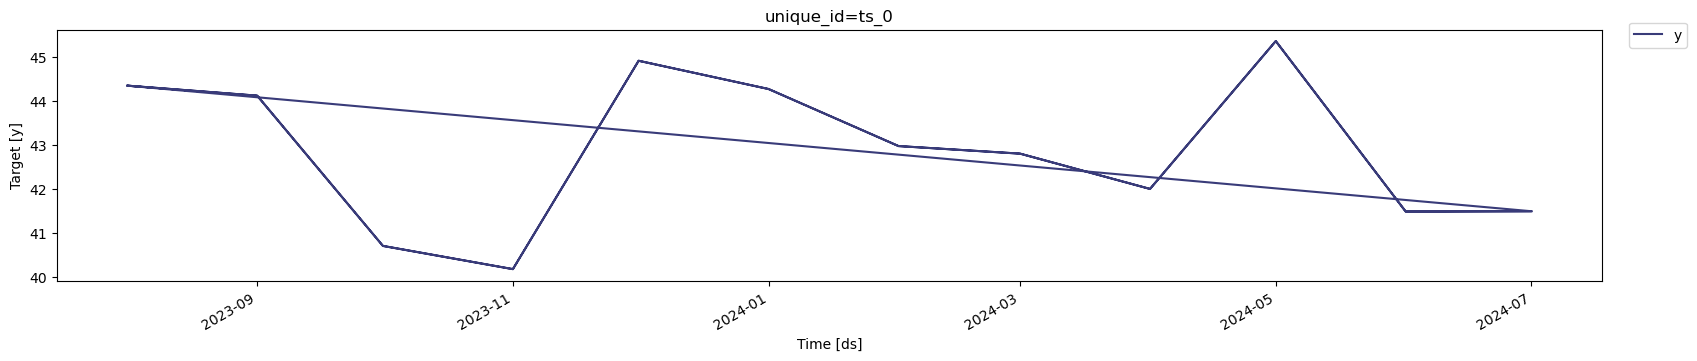

In [119]:
nixtla_client.plot(
    main_forecast[['ds', 'y']], 
    main_forecast, 
    max_insample_length=365, 
    level=[80, 90], 
)

<Axes: ylabel='features'>

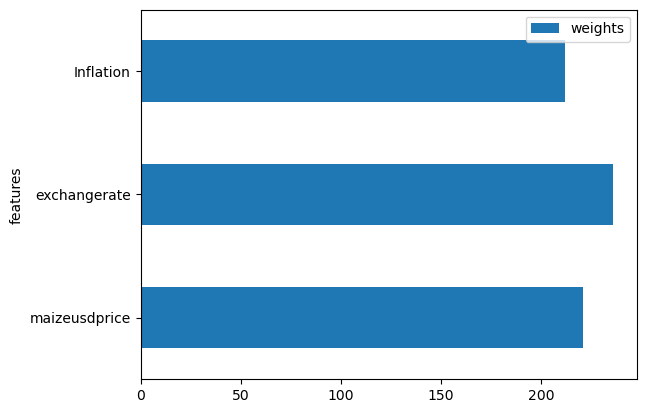

In [91]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

# Training


In [124]:
test = nix_df[-24:]             # 96 = 4 days x 24h/day
input_seq = nix_df[:-24]   # Gets a sequence of 1008 observations (1008 = 42 days * 24h/day)

In [126]:
test

,ds,y,maizeusdprice,exchangerate,Inflation
175,2021-08-01,48.843042,57.189769,6.040,19.634017
176,2021-09-01,48.372817,55.879754,6.050,21.137773
177,2021-10-01,47.663308,51.047985,6.110,22.748613
178,2021-11-01,47.978858,47.456400,6.135,24.466538
179,2021-12-01,48.816815,48.097840,6.150,26.291548
180,2022-01-01,48.930931,50.201780,6.275,28.223642
181,2022-02-01,42.947918,48.708754,6.725,29.281212
182,2022-03-01,45.845350,51.271215,7.525,30.838509
183,2022-04-01,44.021250,48.626015,7.525,32.395807
184,2022-05-01,47.812533,56.400454,7.800,33.953105


In [128]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=24,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


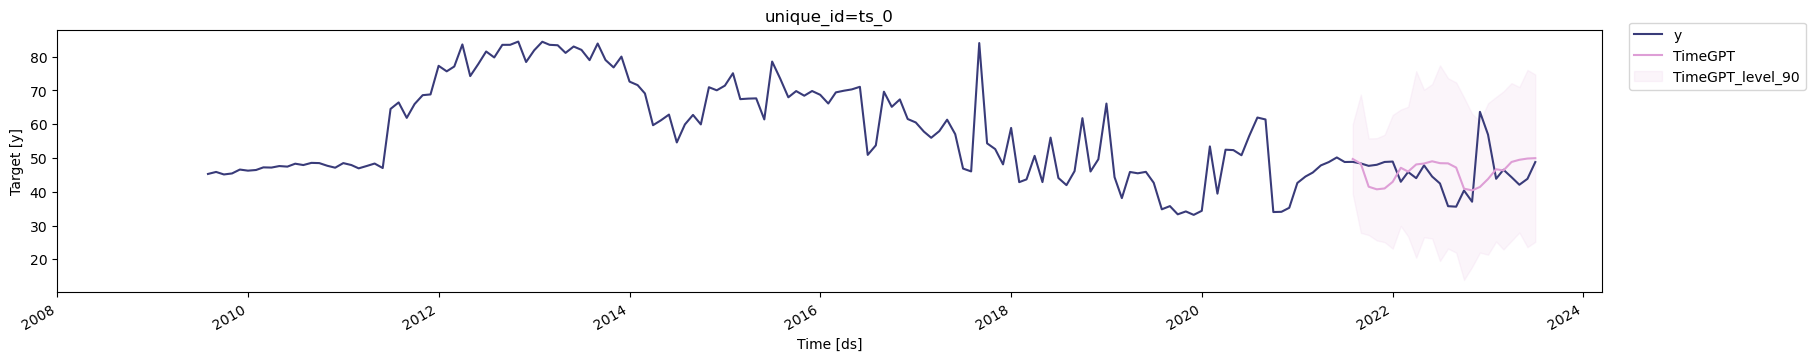

In [133]:
nixtla_client.plot(nix_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [134]:
test = test.copy()

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [142]:
# Create a unique ID based on the index
test = test.reset_index(drop=True)
test['unique_id'] = 'GH'  # Adding 1 to start IDs from 1 instead of 0


In [144]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

evaluation

,unique_id,TimeGPT
0,GH,5.548381


Mean absolute error of 5.548

In [171]:
nix_df

,ds,y,maizeusdprice,exchangerate,Inflation
0,2007-01-01,37.844100,20.495183,0.9210,18.541578
1,2007-02-01,36.425600,22.002383,0.9295,14.262831
2,2007-03-01,36.701883,23.088567,0.9263,13.017348
3,2007-04-01,37.661983,24.117650,0.9270,12.367792
4,2007-05-01,38.772450,24.460667,0.9276,12.314164
...,...,...,...,...,...
194,2023-03-01,46.517338,45.828924,11.5500,49.526084
195,2023-04-01,44.311413,52.308482,11.8000,51.083382
196,2023-05-01,42.071260,54.955418,11.2500,52.640680
197,2023-06-01,43.822793,55.113344,11.3250,54.197978


In [186]:
# 1. Split the Data
train_size = int(len(df) * 0.95)
train_df = nix_df.iloc[:train_size]
test_df = nix_df.iloc[train_size:]



In [187]:
forecast_horizon =12

In [188]:
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')

In [ ]:
# Train the model
main_forecast = nixtla_client.forecast(
    df=train.reset_index(),
    h=len(test),
    target_col='riceusdprice',
    X_df=train_exogenous.reset_index()
)

# Make predictions
predictions_df = nixtla_client.forecast(
    df=test.reset_index(),
    h=len(test),
    target_col='riceusdprice',
    X_df=test_exogenous_future
)

# Evaluate the model
y_true = test['riceusdprice']
y_pred = predictions_df['TimeGPT']  # Replace 'TimeGPT' with the correct column name in your predictions

# Calculate Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['riceusdprice'], label='Train', color='blue', linewidth=1.5)
plt.plot(test.index, y_true, label='True Values', color='orange', linewidth=1.5)
plt.plot(test.index, y_pred, label='Predicted Values', linestyle='--', color='green', linewidth=1.5)
plt.fill_between(test.index, predictions_df['TimeGPT_level_90_lower'], predictions_df['TimeGPT_level_90_upper'], color='pink', alpha=0.3, label='Confidence Interval (90%)')
plt.legend()
plt.title('Rice Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

In [189]:
# Extract forecasted values from train_df 
maize_forecast = train_df['maizeusdprice'].values  
exchangerate_actual = train_df['exchangerate'].values 
inflation_forecast = train_df['Inflation'].values  

# Create DataFrame with future dates and forecasted values
forecast_exogenous_df = pd.DataFrame({
    'ds': future_dates,
    'maizeusdprice': maize_forecast,
    'exchangerate': exchangerate_actual,
    'Inflation': inflation_forecast
})

# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)
forecast_exogenous_df['ds'] = pd.to_datetime(forecast_exogenous_df['ds'], format='%Y-%m-%d')

# Convert to 'YYYY-MM-DD' format, start of the month
forecast_exogenous_df['ds'] = forecast_exogenous_df['ds'].dt.to_period('M').dt.to_timestamp()

ValueError: All arrays must be of the same length

In [176]:
X_df_train = train_df[['ds','riceusdprice', 'maizeusdprice', 'exchangerate', 'Inflation']]


In [ ]:
maize_forecast = maize_forecast.rename(columns={'TimeGPT': 'maizeusdprice_forecast'})

In [178]:
X_df_train

,ds,maizeusdprice,exchangerate,Inflation
0,2007-01-01,20.495183,0.9210,18.541578
1,2007-02-01,22.002383,0.9295,14.262831
2,2007-03-01,23.088567,0.9263,13.017348
3,2007-04-01,24.117650,0.9270,12.367792
4,2007-05-01,24.460667,0.9276,12.314164
...,...,...,...,...
184,2022-05-01,56.400454,7.8000,33.953105
185,2022-06-01,53.642467,8.0250,35.510403
186,2022-07-01,50.335269,8.4500,37.067701
187,2022-08-01,41.018958,10.1000,38.624999


In [179]:
# 2. Train the Model

# Train the model with the training set
trained_model = nixtla_client.forecast(
    df=X_df_train,
    h=12,  # forecast horizon
    finetune_steps=10,  # number of fine-tuning steps
    time_col='ds',
    target_col='riceusdprice',
    X_df = X_df_train
)



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


KeyError: "['y'] not in index"

In [ ]:
# Ensure `X_df` includes exogenous variables for the forecast
X_df = maize_forecast.merge(inflation_forecast, on='ds').merge(exchange_rate_actual, on='ds')

# Forecast with the exogenous variables
test_forecast = nixtla_client.forecast(
    df=test_df,
    h=12,  # forecast horizon
    time_col='ds',
    target_col='riceusdprice',
    X_df=X_df  # Include exogenous variables
)


In [174]:
# 3. Test the Model
# Forecast with the testing set
test_forecast = nixtla_client.forecast(
    df=test_df,
    h=12,  # forecast horizon
    time_col='ds',
    target_col='riceusdprice',
)

# Compare the forecasts with the actual test data
test_df['forecast'] = test_forecast['TimeGPT']
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['riceusdprice'], label='Actual Prices')
plt.plot(test_df['ds'], test_df['forecast'], label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Prices($)')
plt.title('Actual vs Forecasted Prices')
plt.legend()
plt.grid(True)
plt.show()


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/var/folders/fb/7_tr03xs3mz__43hcn2dy5dr0000gn/T/ipykernel_75231/3787486312.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forecast'] = test_forecast['TimeGPT']


KeyError: 'riceusdprice'

<Figure size 1200x600 with 0 Axes>

In [146]:
# Finetuning

In [150]:
nix_df

,ds,y,maizeusdprice,exchangerate,Inflation
0,2007-01-01,37.844100,20.495183,0.9210,18.541578
1,2007-02-01,36.425600,22.002383,0.9295,14.262831
2,2007-03-01,36.701883,23.088567,0.9263,13.017348
3,2007-04-01,37.661983,24.117650,0.9270,12.367792
4,2007-05-01,38.772450,24.460667,0.9276,12.314164
...,...,...,...,...,...
194,2023-03-01,46.517338,45.828924,11.5500,49.526084
195,2023-04-01,44.311413,52.308482,11.8000,51.083382
196,2023-05-01,42.071260,54.955418,11.2500,52.640680
197,2023-06-01,43.822793,55.113344,11.3250,54.197978


In [153]:
# Assuming 'future_exogenous_df' contains future values for exogenous variables
# Prepare future exogenous DataFrame for the next 12 periods (monthly in this example)
future_exogenous_df = pd.DataFrame({
    'ds': pd.date_range(start=nix_df['ds'].max() + pd.DateOffset(months=1), periods=12, freq='MS'),
    'maizeusdprice': X_df['maizeusdprice_forecast'].values * 12,  # Replace 'your_value' with actual forecasted values
    'exchangerate': X_df['exchangerate'].values * 12,
    'Inflation': X_df['Inflation_forecast'].values  * 12
})

# Convert 'ds' to datetime format
future_exogenous_df['ds'] = pd.to_datetime(future_exogenous_df['ds'], format='%Y-%m-%d')

# Ensure 'ds' is in the right format for the forecast
future_exogenous_df['ds'] = future_exogenous_df['ds'].dt.to_period('M').dt.to_timestamp()

# Forecast with the exogenous variables
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=nix_df,
    h=12,
    finetune_steps=10,
    time_col='ds',
    target_col='y',
    X_df=future_exogenous_df  # Include future exogenous variables
)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Using the following exogenous variables: maizeusdprice, exchangerate, Inflation
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [154]:
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=nix_df, h=12, finetune_steps=10,
    time_col='ds', target_col='y',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [160]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df, 
    time_col='ds' , target_col=y,
)

TypeError: unhashable type: 'Series'

In [192]:
# Ensure the frequency is consistent
df = df.asfreq('MS')

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Prepare exogenous variables
def prepare_exogenous(df):
    exog = df[['maizeusdprice', 'exchangerate', 'Inflation']].copy()
    exog['ds'] = exog.index
    return exog

train_exogenous = prepare_exogenous(train)
test_exogenous = prepare_exogenous(test)

# Generate future dates
future_dates = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(), periods=len(test), freq='MS')

# Repeat the last known values for exogenous variables
future_exogenous = pd.DataFrame({
    'maizeusdprice': [test['maizeusdprice'].iloc[-1]] * len(future_dates),
    'exchangerate': [test['exchangerate'].iloc[-1]] * len(future_dates),
    'Inflation': [test['Inflation'].iloc[-1]] * len(future_dates)
}, index=future_dates)

# Combine future exogenous variables with the test set
future_exogenous['ds'] = future_exogenous.index
test_exogenous_future = pd.concat([test_exogenous, future_exogenous])

# Ensure the future exogenous data is in the correct format
test_exogenous_future = test_exogenous_future.reset_index(drop=True)

# Reset index for training and testing data
train_reset = train.reset_index()
test_reset = test.reset_index()

# Initialize Nixtla client
nixtla_client = NixtlaClient(api_key='your_api_key')  # Replace with your API key

# Train the model
main_forecast = nixtla_client.forecast(
    df=train_reset,
    h=len(test),
    target_col='riceusdprice',
    X_df=train_exogenous.reset_index(drop=True)
)

# Make predictions
predictions_df = nixtla_client.forecast(
    df=test_reset,
    h=len(test),
    target_col='riceusdprice',
    X_df=test_exogenous_future
)

# Evaluate the model
y_true = test['riceusdprice']
y_pred = predictions_df['TimeGPT']  # Replace 'TimeGPT' with the correct column name in your predictions

# Calculate Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['riceusdprice'], label='Train', color='blue', linewidth=1.5)
plt.plot(test.index, y_true, label='True Values', color='orange', linewidth=1.5)
plt.plot(test.index, y_pred, label='Predicted Values', linestyle='--', color='green', linewidth=1.5)
plt.fill_between(test.index, predictions_df['TimeGPT_level_90_lower'], predictions_df['TimeGPT_level_90_upper'], color='pink', alpha=0.3, label='Confidence Interval (90%)')
plt.legend()
plt.title('Rice Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


IndexError: single positional indexer is out-of-bounds